In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('display.max_column', None)

data_path = './../data/nba_logreg.csv'
df = pd.read_csv(data_path)

In [3]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

def preprocessing(data, method=None):
    data = data.drop(['Name'], axis=1)
    data.loc[:, '3P%'] = data.loc[:, '3P%'].fillna(0)
    data = data.drop_duplicates()
    
    if method == 'oversample':
        ros = RandomOverSampler(random_state=0)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = ros.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1)
    elif method == 'undersample':
        rus = RandomUnderSampler(random_state=0)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = rus.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1).reset_index(drop=True)
    elif method == 'smote':
        sm = SMOTE(random_state=0)
        X = data.drop('TARGET_5Yrs', axis=1)
        y = data['TARGET_5Yrs']
        X_resampled, y_resampled = sm.fit_resample(X, y)
        data = pd.concat([X_resampled, y_resampled], axis=1)
    
    return data

In [5]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import KFold

def score_classifier(dataset,classifier,labels, folds=3, verbose=True):
    
    """
    This function takes in a dataset, classifier and labels and returns the mean confusion matrix, recall, precision, accuracy and f1 score
    for the classifier using KFold cross validation with the number of folds specified by the user

    Parameters:
    dataset: pandas dataframe
    classifier: sklearn classifier
    labels: pandas series
    folds: int

    Returns:
    dict: dictionary containing mean confusion matrix, recall, precision, accuracy and f1 score
    """

    kf = KFold(n_splits=folds,random_state=50,shuffle=True)
    confusion_mat_list = []
    recall_list = []
    precision_list = []
    accuracy_list = []
    f1_list = []

    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset.iloc[training_ids]
        training_labels = labels.iloc[training_ids]
        test_set = dataset.iloc[test_ids]
        test_labels = labels.iloc[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)

        confusion_mat = confusion_matrix(test_labels,predicted_labels)
        recall = recall_score(test_labels, predicted_labels)
        precision = precision_score(test_labels, predicted_labels)
        accuracy = classifier.score(test_set, test_labels)
        f1 = 2 * (precision * recall) / (precision + recall)

        recall_list.append(recall)
        precision_list.append(precision)
        accuracy_list.append(accuracy)
        f1_list.append(f1)
        confusion_mat_list.append(confusion_mat)

    recall = np.mean(recall_list)
    precision = np.mean(precision_list)
    accuracy = np.mean(accuracy_list)
    f1 = np.mean(f1_list)
    confusion_mat = np.mean(confusion_mat_list,axis=0).astype(int)
    confusion_mat_df = pd.DataFrame(confusion_mat,columns=['Predicted 0','Predicted 1'],index=['Actual 0','Actual 1'])

    if verbose:
        print(f"confusion_mat: \n {confusion_mat_df}")
        print(f"recall:{recall}")
        print(f"precision:{precision}")
        print(f"accuracy:{accuracy}")
        print(f"f1:{f1}")
    return {'confusion_mat':confusion_mat,'recall':recall,'precision':precision,'accuracy':accuracy,'f1':f1, 'classifier':classifier}


In [87]:
# first scores

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

df_test = df.copy()
X = df_test.drop(['TARGET_5Yrs', 'Name'], axis=1)
y = df_test['TARGET_5Yrs']

# fill nan
X.loc[:, '3P%'] = X.loc[:, '3P%'].fillna(0)

pipeline = Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', SVC())])

scores = score_classifier(X, pipeline, y, folds=5)


confusion_mat: 
           Predicted 0  Predicted 1
Actual 0           52           49
Actual 1           28          137
recall:0.8283688155659495
precision:0.737618408158071
accuracy:0.7104477611940297
f1:0.7795266617095927


In [6]:
# model search

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline

target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
models = [LogisticRegression(), RandomForestClassifier(), SVC(), GradientBoostingClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), AdaBoostClassifier(), XGBClassifier()]
model_names = ['LogisticRegression', 'RandomForestClassifier', 'SVC', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'AdaBoostClassifier', 'XGBClassifier']

results = []

for model, model_name in zip(models, model_names):
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
    result = score_classifier(data_processed.drop(target, axis=1), pipeline, data_processed[target], folds=4, verbose=False)
    result['model_name'] = model_name
    results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1', ascending=False)
results_df = results_df.reset_index(drop=True)
results_df

,confusion_mat,recall,precision,accuracy,f1,classifier,model_name
0,"[[69, 57], [35, 170]]",0.827512,0.749402,0.721386,0.786348,"(StandardScaler(), SVC())",SVC
1,"[[66, 59], [37, 168]]",0.817619,0.738949,0.707831,0.776090,"(StandardScaler(), LogisticRegression())",LogisticRegression
2,"[[66, 59], [40, 165]]",0.803144,0.735562,0.698795,0.767675,"(StandardScaler(), ([DecisionTreeRegressor(cri...",GradientBoostingClassifier
3,"[[66, 60], [43, 162]]",0.789960,0.730966,0.689006,0.759102,"(StandardScaler(), (DecisionTreeClassifier(max...",RandomForestClassifier
4,"[[67, 58], [47, 158]]",0.769095,0.731328,0.681476,0.749652,"(StandardScaler(), (DecisionTreeClassifier(max...",AdaBoostClassifier
5,"[[65, 60], [46, 159]]",0.775847,0.725193,0.677711,0.749401,"(StandardScaler(), KNeighborsClassifier())",KNeighborsClassifier
6,"[[64, 61], [51, 154]]",0.748303,0.714506,0.658886,0.730861,"(StandardScaler(), XGBClassifier(base_score=No...",XGBClassifier
7,"[[65, 60], [69, 136]]",0.663871,0.692213,0.608434,0.677678,"(StandardScaler(), DecisionTreeClassifier())",DecisionTreeClassifier


In [39]:
# model search - feature selection

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline

target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'PTS', 'FGM', 'MIN', 'FTA', 'FTM', 'REB', 'OREB', 'FGA']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

models = [LogisticRegression(), RandomForestClassifier(), SVC(), GradientBoostingClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), AdaBoostClassifier(), XGBClassifier()]
model_names = ['LogisticRegression', 'RandomForestClassifier', 'SVC', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'AdaBoostClassifier', 'XGBClassifier']

results = []

for model, model_name in zip(models, model_names):
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
    result = score_classifier(X, pipeline, y, folds=4, verbose=False)
    result['model_name'] = model_name
    results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1', ascending=False)
results_df = results_df.reset_index(drop=True)
results_df

,confusion_mat,recall,precision,accuracy,f1,classifier,model_name
0,"[[69, 56], [39, 166]]",0.807032,0.745591,0.709337,0.774982,"(StandardScaler(), SVC())",SVC
1,"[[67, 58], [39, 166]]",0.809057,0.740802,0.705572,0.772818,"(StandardScaler(), LogisticRegression())",LogisticRegression
2,"[[69, 56], [42, 164]]",0.795662,0.743451,0.703313,0.768308,"(StandardScaler(), ([DecisionTreeRegressor(cri...",GradientBoostingClassifier
3,"[[69, 56], [47, 158]]",0.769447,0.737294,0.686747,0.752785,"(StandardScaler(), (DecisionTreeClassifier(max...",AdaBoostClassifier
4,"[[66, 59], [45, 160]]",0.777813,0.729946,0.683735,0.752778,"(StandardScaler(), (DecisionTreeClassifier(max...",RandomForestClassifier
5,"[[64, 62], [50, 155]]",0.755328,0.714996,0.661898,0.734181,"(StandardScaler(), KNeighborsClassifier())",KNeighborsClassifier
6,"[[63, 62], [51, 154]]",0.748388,0.710106,0.655120,0.728496,"(StandardScaler(), XGBClassifier(base_score=No...",XGBClassifier
7,"[[63, 62], [69, 136]]",0.662225,0.686507,0.603163,0.674089,"(StandardScaler(), DecisionTreeClassifier())",DecisionTreeClassifier


In [41]:
# model search - feature selection

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline

target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'PTS', 'FGM', 'MIN', 'FTA', 'FTM', 'REB', 'OREB', 'FGA']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[('model', LogisticRegression(C=0.1, solver='liblinear'))])
svc = Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC())])

models = [lr, svc]
model_names = ['LogisticRegression', 'SVC']

results = []

for model, model_name in zip(models, model_names):
    result = score_classifier(X, model, y, folds=5, verbose=False)
    result['model_name'] = model_name
    results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1', ascending=False)
results_df = results_df.reset_index(drop=True)
results_df

,confusion_mat,recall,precision,accuracy,f1,classifier,model_name
0,"[[43, 57], [21, 143]]",0.871370,0.716554,0.705555,0.785391,"(LogisticRegression(C=0.1, solver='liblinear'))",LogisticRegression
1,"[[55, 45], [30, 134]]",0.814348,0.747913,0.714592,0.779292,"(StandardScaler(), SVC())",SVC


In [44]:
target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[('model', LogisticRegression(C=0.1, solver='liblinear'))])
svc = Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC())])

models = [lr, svc]
model_names = ['LogisticRegression', 'SVC']

results = []

for model, model_name in zip(models, model_names):
    result = score_classifier(X, model, y, folds=5, verbose=False)
    result['model_name'] = model_name
    results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1', ascending=False)
results_df = results_df.reset_index(drop=True)
results_df

,confusion_mat,recall,precision,accuracy,f1,classifier,model_name
0,"[[36, 64], [19, 145]]",0.883783,0.692918,0.685206,0.776392,"(LogisticRegression(C=0.1, solver='liblinear'))",LogisticRegression
1,"[[49, 51], [34, 130]]",0.793900,0.719427,0.679200,0.754018,"(StandardScaler(), SVC())",SVC


In [43]:
target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'PTS', 'FGM', 'MIN', 'FTA', 'FTM', 'REB', 'OREB', 'FGA']
data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[('model', LogisticRegression(C=0.1, solver='liblinear'))])
svc = Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC())])

models = [lr, svc]
model_names = ['LogisticRegression', 'SVC']

results = []

for model, model_name in zip(models, model_names):
    result = score_classifier(X, model, y, folds=5, verbose=False)
    result['model_name'] = model_name
    results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1', ascending=False)
results_df = results_df.reset_index(drop=True)
results_df

,confusion_mat,recall,precision,accuracy,f1,classifier,model_name
0,"[[43, 57], [21, 143]]",0.871370,0.716554,0.705555,0.785391,"(LogisticRegression(C=0.1, solver='liblinear'))",LogisticRegression
1,"[[55, 45], [30, 134]]",0.814348,0.747913,0.714592,0.779292,"(StandardScaler(), SVC())",SVC


In [48]:
from sklearn.model_selection import RandomizedSearchCV

target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(2, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=10)), 
    ('model', LogisticRegression())])

param_grid = {'polynomial_features__degree': range(1, 5),
                'select_k_best__k': range(1, 19),
                'model__C': [0.01, 0.1, 1, 10],
                'model__solver': ['liblinear', 'lbfgs', 'saga']}

random_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1, n_iter=100)
random_search.fit(X, y)

print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'select_k_best__k': 12, 'polynomial_features__degree': 1, 'model__solver': 'liblinear', 'model__C': 0.1}


In [52]:
from sklearn.model_selection import RandomizedSearchCV

target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(2, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=10)), 
    ('model', LogisticRegression())])

param_grid = {'polynomial_features__degree': range(1, 3),
                'select_k_best__k': range(1, 19),
                'model__C': [0.08, 0.1, 0.12],
                'model__solver': ['liblinear']}

random_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1, n_iter=100)
random_search.fit(X, y)

print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'select_k_best__k': 9, 'polynomial_features__degree': 1, 'model__solver': 'liblinear', 'model__C': 0.12}


In [54]:
target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(1, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=9)), 
    ('model', LogisticRegression(C=0.1, solver='liblinear'))])

result = score_classifier(X, pipeline, y, folds=5, verbose=False)
result['model_name'] = 'LogisticRegression'

result

{'confusion_mat': array([[ 43,  57],
        [ 21, 143]]),
 'recall': 0.8679412336549746,
 'precision': 0.7136693268472322,
 'accuracy': 0.7010441197332955,
 'f1': 0.7822574483137785,
 'classifier': Pipeline(steps=[('polynomial_features',
                  PolynomialFeatures(degree=1, include_bias=False)),
                 ('select_k_best', SelectKBest(k=9)),
                 ('model', LogisticRegression(C=0.1, solver='liblinear'))]),
 'model_name': 'LogisticRegression'}

In [70]:
from sklearn.model_selection import RandomizedSearchCV

target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(2, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=10)), 
    ('model', SVC())])

param_grid = {'polynomial_features__degree': range(1, 3),
                'select_k_best__k': range(1, 19),
                'model__C': [0.01, 0.1, 1, 10, 100, 1000],
                'model__kernel': ['poly'],
                'model__gamma': ['scale']}


random_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1, n_iter=100)
random_search.fit(X, y)

print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'select_k_best__k': 17, 'polynomial_features__degree': 1, 'model__kernel': 'poly', 'model__gamma': 'scale', 'model__C': 0.01}


In [74]:
target = 'TARGET_5Yrs'
balance_method = None

data_processed = preprocessing(df, balance_method)
X = data_processed.drop(target, axis=1)
y = data_processed[target]

pipeline = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(1, include_bias=False)), 
    ('select_k_best', SelectKBest(f_classif, k=16)), 
    ('model', SVC(C=1, kernel='rbf', gamma='scale'))])

result = score_classifier(X, pipeline, y, folds=5, verbose=False)
result['model_name'] = 'LogisticRegression'

result

{'confusion_mat': array([[ 47,  53],
        [ 25, 139]]),
 'recall': 0.8470344173344924,
 'precision': 0.7218069000323044,
 'accuracy': 0.702536530004256,
 'f1': 0.7788139894283326,
 'classifier': Pipeline(steps=[('polynomial_features',
                  PolynomialFeatures(degree=1, include_bias=False)),
                 ('select_k_best', SelectKBest(k=16)), ('model', SVC(C=1))]),
 'model_name': 'LogisticRegression'}

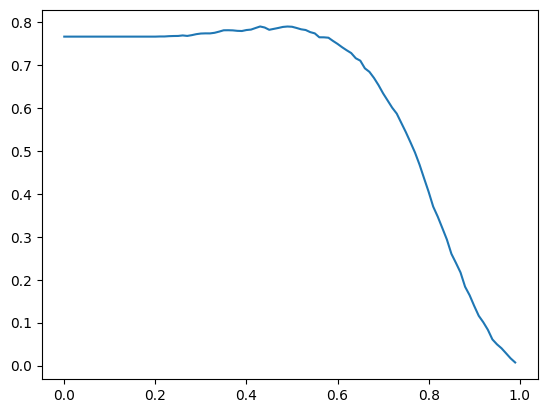

0.43

In [75]:
from sklearn.metrics import f1_score
target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'PTS', 'FGM', 'MIN', 'FTA', 'FTM', 'REB', 'OREB', 'FGA']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[('model', LogisticRegression(C=0.1, solver='liblinear'))])

result = score_classifier(X, lr, y, folds=5, verbose=False)
probabilities = lr.predict_proba(X)

thresholds = np.arange(0, 1, 0.01)
scores = []
for threshold in thresholds:
    predictions = probabilities[:, 1] > threshold
    scores.append(f1_score(y, predictions))

plt.plot(thresholds, scores)
plt.show()

thresholds[np.argmax(scores)]


In [76]:
def predict_threshold(model, X, threshold=0.43):
    probabilities = model.predict_proba(X)
    predictions = probabilities[:, 1] > threshold
    return predictions

In [77]:
# final model performance

target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'PTS', 'FGM', 'MIN', 'FTA', 'FTM', 'REB', 'OREB', 'FGA']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[('model', LogisticRegression(C=0.1, solver='liblinear'))])

result = score_classifier(X, lr, y, folds=5, verbose=False)

result


{'confusion_mat': array([[ 43,  57],
        [ 21, 143]]),
 'recall': 0.8713698050835461,
 'precision': 0.7165539422318477,
 'accuracy': 0.7055553979287843,
 'f1': 0.785390607582708,
 'classifier': Pipeline(steps=[('model', LogisticRegression(C=0.1, solver='liblinear'))])}

In [ ]:
# save model

import joblib

target = 'TARGET_5Yrs'
balance_method = None
features_selected = ['GP', 'PTS', 'FGM', 'MIN', 'FTA', 'FTM', 'REB', 'OREB', 'FGA']

data_processed = preprocessing(df, balance_method)
X = data_processed[features_selected]
y = data_processed[target]

lr = Pipeline(steps=[('model', LogisticRegression(C=0.1, solver='liblinear'))])
lr.fit(X, y)

joblib.dump(lr, './../models/model_1.pkl')
